<a href="https://colab.research.google.com/github/miuAvlad/Traiding-predictions-using-LSTM-KNN-/blob/main/traiding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

import torch
import torch.nn as nn

import warnings

warnings.filterwarnings('ignore')

In [ ]:
#!pip install pandas_ta
# !pip install Flask yfinance


In [ ]:
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# # Simbolul pentru care se dorește descărcarea datelor
# single_symbol = 'ABBD'

# # Data de azi ca end_date
# end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
# start_date = pd.to_datetime(end_date) - pd.DateOffset(years=20)

# # Descărcarea datelor de pe Yahoo Finance
# df = yf.download(tickers=single_symbol, start=start_date, end=end_date)

# # Setarea numelui indexului și a coloanelor
# df.index.names = ['date']
# df.columns = df.columns.str.lower()

# # Afișarea datelor
# df

Extragerea datelor

In [ ]:
# Extrageți lista companiilor din S&P 500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]


sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

#'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'INTC', 'AMD', 'ADBE', 'GOOG', 'BRK']
single_symbol = 'NVDA'


end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=20)

df = yf.download(tickers=single_symbol,
                 start=start_date,
                 end=end_date)

df.index.names = ['date']
df.columns = df.columns.str.lower()
df


[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2004-07-01,0.172500,0.172750,0.162500,0.162750,0.149279,505620000
2004-07-02,0.164500,0.164583,0.159250,0.160500,0.147215,294948000
2004-07-06,0.158583,0.160250,0.149333,0.151083,0.138577,575388000
2004-07-07,0.153000,0.156167,0.151083,0.151833,0.139265,344136000
2004-07-08,0.150417,0.152917,0.146917,0.147167,0.134986,430056000
...,...,...,...,...,...,...
2024-06-24,123.239998,124.459999,118.040001,118.110001,118.110001,476060900
2024-06-25,121.199997,126.500000,119.320000,126.089996,126.089996,425787500
2024-06-26,126.129997,128.119995,122.599998,126.400002,126.400002,362975900


Adaugarea indicatorilor de performanta

In [ ]:

df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open']))**2)
df['rsi'] = ta.rsi(df['adj close'], length=20)
bb = ta.bbands(df['adj close'], length=20)
df['bb_low'] = bb['BBL_20_2.0']
df['bb_mid'] = bb['BBM_20_2.0']
df['bb_high'] = bb['BBU_20_2.0']

def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = compute_atr(df)

def compute_macd(close):
    macd = ta.macd(close, fast=12, slow=26, signal=9)['MACD_12_26_9']
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = compute_macd(df['adj close'])

df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

df


,open,high,low,close,adj close,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2004-07-01,0.172500,0.172750,0.162500,0.162750,0.149279,505620000,-0.006204,NaN,NaN,NaN,NaN,NaN,NaN,75.478281
2004-07-02,0.164500,0.164583,0.159250,0.160500,0.147215,294948000,-0.004218,NaN,NaN,NaN,NaN,NaN,NaN,43.420755
2004-07-06,0.158583,0.160250,0.149333,0.151083,0.138577,575388000,-0.004535,NaN,NaN,NaN,NaN,NaN,NaN,79.735748
2004-07-07,0.153000,0.156167,0.151083,0.151833,0.139265,344136000,-0.002870,NaN,NaN,NaN,NaN,NaN,NaN,47.926198
2004-07-08,0.150417,0.152917,0.146917,0.147167,0.134986,430056000,-0.003725,NaN,NaN,NaN,NaN,NaN,NaN,58.051359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,123.239998,124.459999,118.040001,118.110001,118.110001,476060900,0.000704,56.334424,105.265526,121.119823,136.974121,8.120983,9.241029,56227.553190
2024-06-25,121.199997,126.500000,119.320000,126.089996,126.089996,425787500,0.001103,61.644193,107.628389,122.101310,136.574231,8.439708,8.708263,53687.544316
2024-06-26,126.129997,128.119995,122.599998,126.400002,126.400002,362975900,0.000968,61.833976,108.651328,122.726728,136.802128,8.417250,8.219697,45880.154314


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

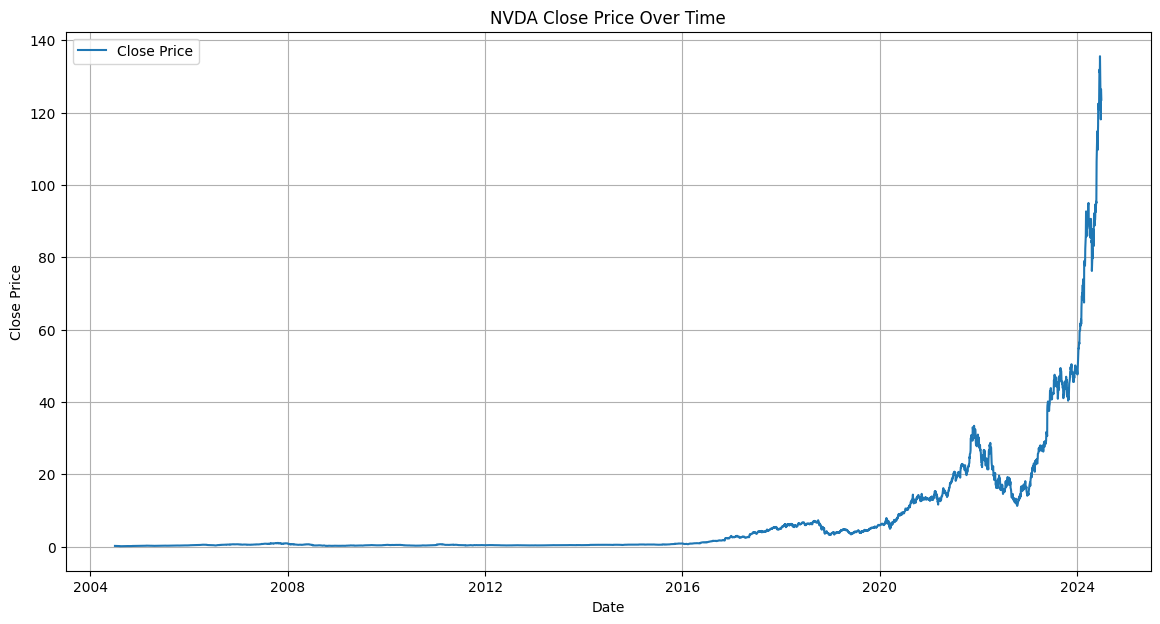

In [ ]:
df.reset_index(inplace=True)


plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{single_symbol} Close Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

Setarea lagului pentru antrenament

In [ ]:
from copy import deepcopy as dc


def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)


    for i in range(1, n_steps):
        df[f'close(t-{i})'] = df['close'].shift(i)


    indicators = ['garman_klass_vol', 'rsi', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd', 'dollar_volume']
    for indicator in indicators:
        for i in range(1, n_steps):
            df[f'{indicator}(t-{i})'] = df[indicator].shift(i)


    df.dropna(inplace=True)

    return df

lookback = 8
shifted_df = prepare_dataframe_for_lstm(df,lookback)
shifted_df

,date,open,high,low,close,adj close,volume,garman_klass_vol,rsi,bb_low,...,macd(t-5),macd(t-6),macd(t-7),dollar_volume(t-1),dollar_volume(t-2),dollar_volume(t-3),dollar_volume(t-4),dollar_volume(t-5),dollar_volume(t-6),dollar_volume(t-7)
32,2004-08-17,0.088583,0.091917,0.087750,0.091417,0.083850,744912000,-0.000088,31.528983,0.064623,...,-0.212358,-0.211294,-0.208966,42.269131,65.465913,50.418367,76.027268,166.719637,118.896874,366.803416
33,2004-08-18,0.091833,0.097500,0.091083,0.097500,0.089430,872424000,0.002046,36.375245,0.063738,...,-0.213233,-0.212358,-0.211294,62.460968,42.269131,65.465913,50.418367,76.027268,166.719637,118.896874
34,2004-08-19,0.096917,0.098667,0.095667,0.097167,0.089124,724404000,-0.002238,36.227473,0.063091,...,-0.213899,-0.213233,-0.212358,78.020564,62.460968,42.269131,65.465913,50.418367,76.027268,166.719637
35,2004-08-20,0.096667,0.104333,0.096333,0.102917,0.094398,1199040000,0.002964,40.612092,0.062888,...,-0.213900,-0.213899,-0.213233,64.561902,78.020564,62.460968,42.269131,65.465913,50.418367,76.027268
36,2004-08-23,0.104583,0.106250,0.104000,0.105167,0.096462,800028000,-0.002295,42.247629,0.062768,...,-0.213768,-0.213900,-0.213899,113.187245,64.561902,78.020564,62.460968,42.269131,65.465913,50.418367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2024-06-24,123.239998,124.459999,118.040001,118.110001,118.110001,476060900,0.000704,56.334424,105.265526,...,11.186641,10.706562,10.218533,82964.698279,67713.750720,39905.953397,37788.305079,40793.175862,33789.910404,37509.293086
5029,2024-06-25,121.199997,126.500000,119.320000,126.089996,126.089996,425787500,0.001103,61.644193,107.628389,...,11.345054,11.186641,10.706562,56227.553190,82964.698279,67713.750720,39905.953397,37788.305079,40793.175862,33789.910404
5030,2024-06-26,126.129997,128.119995,122.599998,126.400002,126.400002,362975900,0.000968,61.833976,108.651328,...,11.787440,11.345054,11.186641,53687.544316,56227.553190,82964.698279,67713.750720,39905.953397,37788.305079,40793.175862
5031,2024-06-27,124.099998,126.410004,122.919998,123.989998,123.989998,252571700,0.000392,59.427734,109.581146,...,11.528130,11.787440,11.345054,45880.154314,53687.544316,56227.553190,82964.698279,67713.750720,39905.953397,37788.305079


In [ ]:
# shifted_df_as_np = shifted_df.to_numpy()
# shifted_df_as_np

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1,1))
# shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)



from sklearn.preprocessing import MinMaxScaler
if 'date' in shifted_df.columns:

    shifted_df_as_np = shifted_df.drop(columns=['date']).to_numpy()
else:
    shifted_df_as_np = shifted_df.to_numpy()

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-1.        , -1.        , -1.        , ..., -0.99711492,
        -0.99807186, -0.99311123],
       [-0.99995348, -0.99992062, -0.99994896, ..., -0.99892968,
        -0.99711492, -0.99807186],
       [-0.9998807 , -0.99990403, -0.99987876, ..., -0.99944211,
        -0.99892968, -0.99711492],
       ...,
       [ 0.80431083,  0.82028617,  0.87611234, ..., -0.20193085,
        -0.2443051 , -0.18417749],
       [ 0.77525095,  0.79597374,  0.88101271, ...,  0.35450457,
        -0.20193085, -0.2443051 ],
       [ 0.7821223 ,  0.8144569 ,  0.87840941, ...,  0.6596768 ,
         0.35450457, -0.20193085]])

In [ ]:
x = np.delete(shifted_df_as_np, [3, 4], axis=1)
y = shifted_df_as_np[:, [3, 4]]

print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')



x shape: (5001, 75)
y shape: (5001, 2)


In [ ]:
split_index = int(len(x) *0.95)

split_index

4750

In [ ]:
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train.shape,x_test.shape,y_train.shape,y_test.shape


((4750, 75), (251, 75), (4750, 2), (251, 2))

In [ ]:
num_caracteristici=x_train.shape[1]

x_train = x_train.reshape((x_train.shape[0], num_caracteristici, 1))
x_test = x_test.reshape((x_test.shape[0], num_caracteristici, 1))

y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

print(f'x_train shape after reshaping: {x_train.shape}')
print(f'x_test shape after reshaping: {x_test.shape}')
print(f'y_train shape after reshaping: {y_train.shape}')
print(f'y_test shape after reshaping: {y_test.shape}')

x_train shape after reshaping: (4750, 75, 1)
x_test shape after reshaping: (251, 75, 1)
y_train shape after reshaping: (4750, 2)
y_test shape after reshaping: (251, 2)


In [ ]:
x_test = torch.tensor(x_test).float()
x_train = torch.tensor(x_train).float()
y_test = torch.tensor(y_test).float()
y_train = torch.tensor(y_train).float()

x_train.shape,x_test.shape,y_train.shape,y_test.shape

(torch.Size([4750, 75, 1]),
 torch.Size([251, 75, 1]),
 torch.Size([4750, 2]),
 torch.Size([251, 2]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)



In [ ]:
train_dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size =32

train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = batch_size,shuffle = False)


In [ ]:
for _,batch in enumerate(train_loader):
  x_batch,y_batch = batch[0].to(device),batch[1].to(device)
  print(x_batch.shape,y_batch.shape)
  break

torch.Size([32, 75, 1]) torch.Size([32, 2])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parametrii modelului
input_size = 1
hidden_size = 4
num_stacked_layers = 2
output_size = 2


# Initializeaza modelul
model = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:

def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)


        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0
    print()


In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
learning_rate = 0.001
num_epochs = 200
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.275

Val Loss: 1.003
***************************************************

Epoch: 2
Batch 100, Loss: 0.012

Val Loss: 0.993
***************************************************

Epoch: 3
Batch 100, Loss: 0.012

Val Loss: 0.984
***************************************************

Epoch: 4
Batch 100, Loss: 0.011

Val Loss: 0.958
***************************************************

Epoch: 5
Batch 100, Loss: 0.011

Val Loss: 0.928
***************************************************

Epoch: 6
Batch 100, Loss: 0.011

Val Loss: 0.905
***************************************************

Epoch: 7
Batch 100, Loss: 0.010

Val Loss: 0.764
***************************************************

Epoch: 8
Batch 100, Loss: 0.003

Val Loss: 0.528
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.484
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.459
********************************

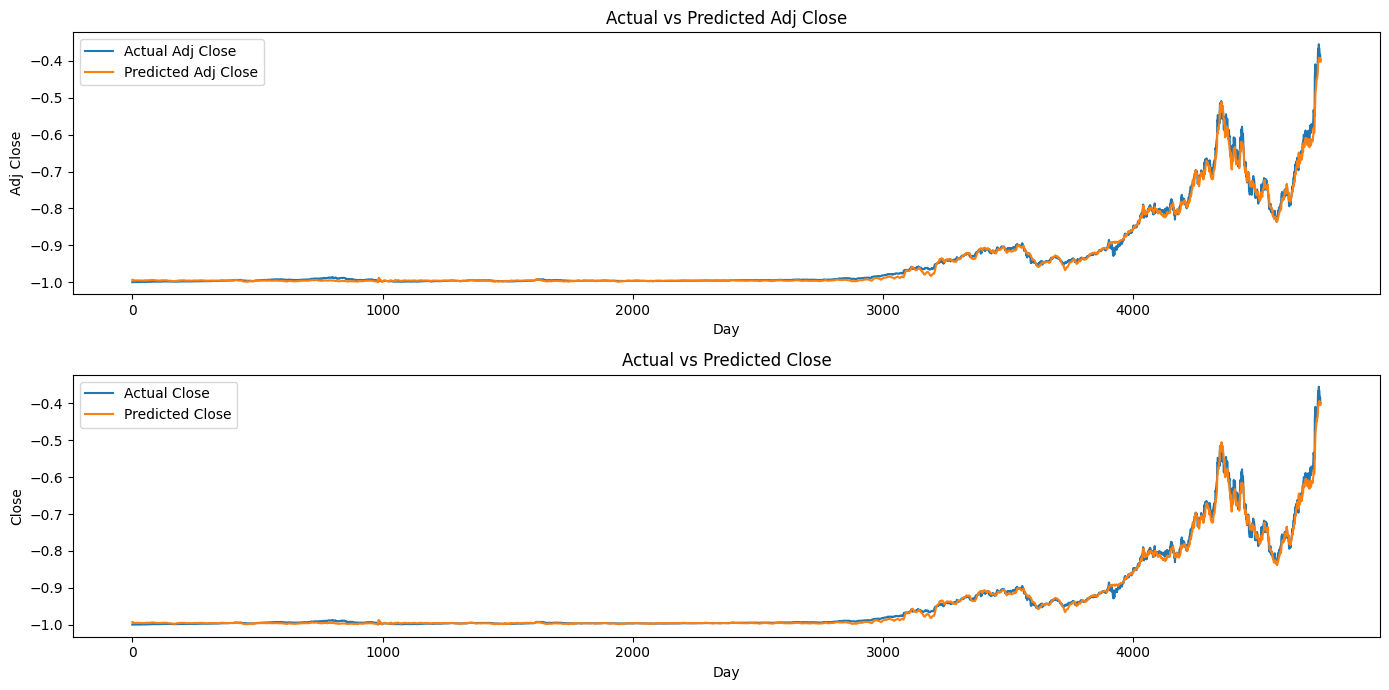

In [ ]:

with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()


predicted_adj_close = predicted[:, 0]
predicted_close = predicted[:, 1]


y_train_adj_close = y_train[:, 0].to('cpu').numpy()
y_train_close = y_train[:, 1].to('cpu').numpy()


plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(y_train_adj_close, label='Actual Adj Close')
plt.plot(predicted_adj_close, label='Predicted Adj Close')
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.title('Actual vs Predicted Adj Close')


plt.subplot(2, 1, 2)
plt.plot(y_train_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close')


plt.tight_layout()
plt.show()


In [ ]:
import json

close_last_60 = y_train_close[-60:]
predicet_close_last_60 = predicted_close[-60:]

# Creează un DataFrame pentru a adăuga datele și a le formata corespunzător
dates1 = pd.date_range(end=pd.to_datetime('today'), periods=60, freq='B')  # Frecvența 'B' înseamnă doar zile lucrătoare
df_pred1 = pd.DataFrame({'Date': dates1, 'Close': close_last_60})

dates2 = pd.date_range(end=pd.to_datetime('today'), periods=60, freq='B')  # Frecvența 'B' înseamnă doar zile lucrătoare
df_pred2 = pd.DataFrame({'Date': dates2, 'Predicted_Close': predicet_close_last_60})

# Formatează coloana 'Date' ca string
df_pred1['Date'] = df_pred1['Date'].dt.strftime('%Y-%m-%d')
df_pred2['Date'] = df_pred2['Date'].dt.strftime('%Y-%m-%d')

# Convertirea DataFrame-ului în JSON
close_json = df_pred1.to_dict(orient='records')
predicted_close_json = df_pred2.to_dict(orient='records')

# Afișează JSON-ul rezultat
print(predicted_close_json)
print(close_json)


# Salvează JSON-ul într-un fișier
with open('close_last_60_GOOGL.json', 'w') as json_file:
    json.dump(close_json, json_file, indent=4)
with open('predicted_close_last_60_GOOGL.json', 'w') as json_file:
    json.dump(predicted_close_json, json_file, indent=4)


print("JSON-ul a fost salvat în fișierul 'predicted_close_last_60.json'")

[{'Date': '2024-04-09', 'Predicted_Close': -0.606399416923523}, {'Date': '2024-04-10', 'Predicted_Close': -0.6059770584106445}, {'Date': '2024-04-11', 'Predicted_Close': -0.6120367050170898}, {'Date': '2024-04-12', 'Predicted_Close': -0.6097985506057739}, {'Date': '2024-04-15', 'Predicted_Close': -0.6146986484527588}, {'Date': '2024-04-16', 'Predicted_Close': -0.6148818731307983}, {'Date': '2024-04-17', 'Predicted_Close': -0.622983455657959}, {'Date': '2024-04-18', 'Predicted_Close': -0.6225359439849854}, {'Date': '2024-04-19', 'Predicted_Close': -0.6258944869041443}, {'Date': '2024-04-22', 'Predicted_Close': -0.608590304851532}, {'Date': '2024-04-23', 'Predicted_Close': -0.6176093816757202}, {'Date': '2024-04-24', 'Predicted_Close': -0.6192866563796997}, {'Date': '2024-04-25', 'Predicted_Close': -0.6264677047729492}, {'Date': '2024-04-26', 'Predicted_Close': -0.6270779371261597}, {'Date': '2024-04-29', 'Predicted_Close': -0.6316356658935547}, {'Date': '2024-04-30', 'Predicted_Close': 

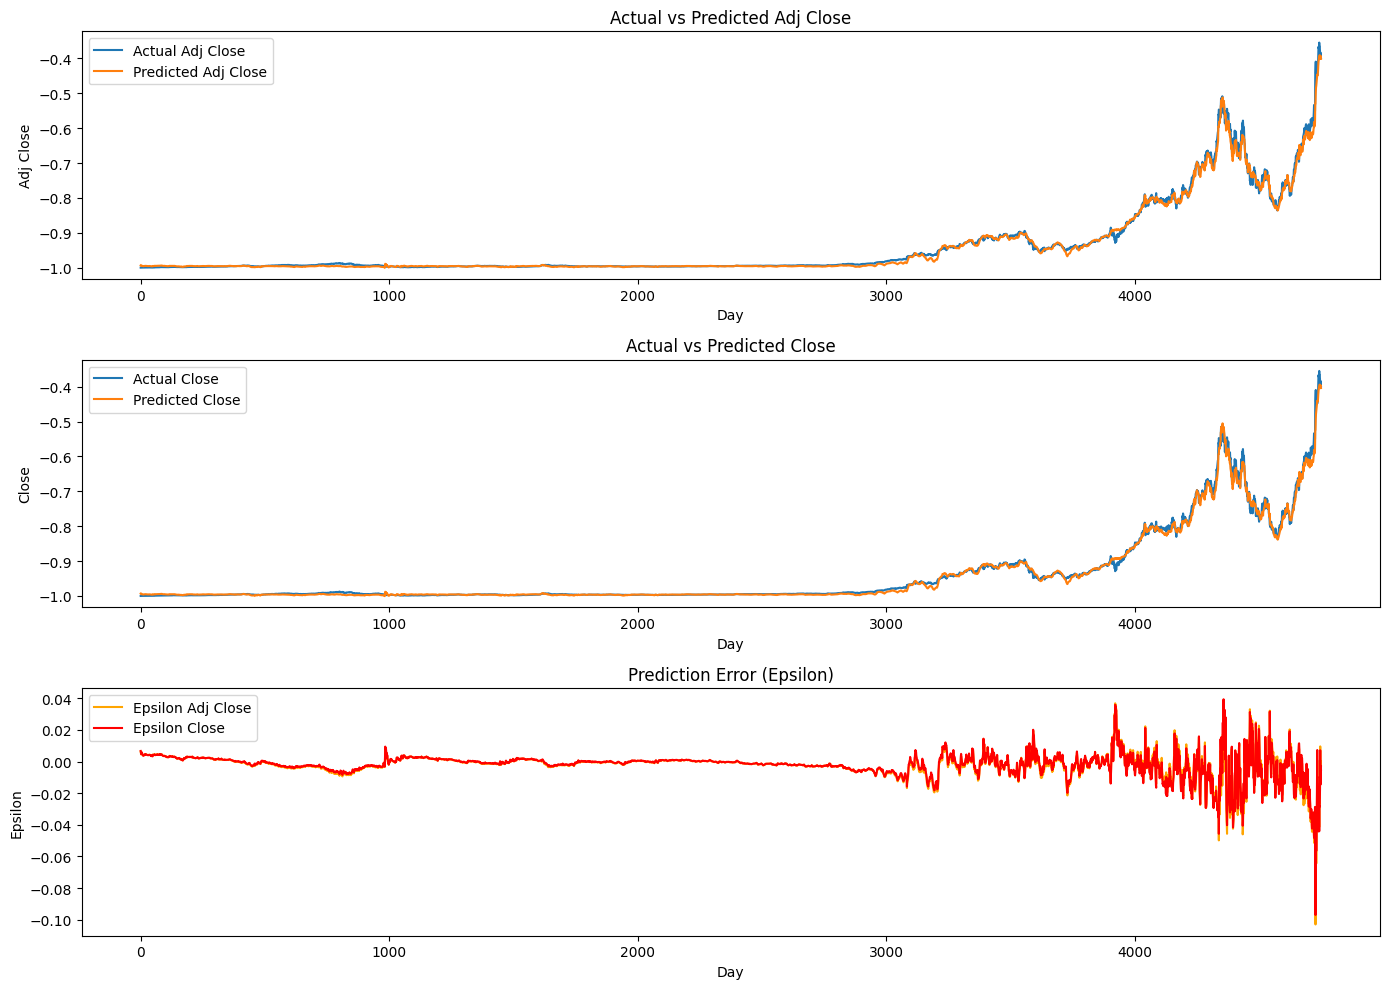

In [ ]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()


predicted_adj_close = predicted[:, 0]
predicted_close = predicted[:, 1]


y_train_adj_close = y_train[:, 0].to('cpu').numpy()
y_train_close = y_train[:, 1].to('cpu').numpy()

epsilon_adj_close = predicted_adj_close - y_train_adj_close
epsilon_close = predicted_close - y_train_close


plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(y_train_adj_close, label='Actual Adj Close')
plt.plot(predicted_adj_close, label='Predicted Adj Close')
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.title('Actual vs Predicted Adj Close')


plt.subplot(3, 1, 2)
plt.plot(y_train_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close')

plt.subplot(3, 1, 3)
plt.plot(epsilon_adj_close, label='Epsilon Adj Close', color='orange')
plt.plot(epsilon_close, label='Epsilon Close', color='red')
plt.xlabel('Day')
plt.ylabel('Epsilon')
plt.legend()
plt.title('Prediction Error (Epsilon)')


plt.tight_layout()
plt.show()

In [ ]:
epsilon_adj_close_negative = epsilon_adj_close[epsilon_adj_close < 0]
epsilon_close_negative = epsilon_close[epsilon_close < 0]

mean_negative_adj_close = np.mean(epsilon_adj_close_negative)
mean_negative_close = np.mean(epsilon_close_negative)

print(f"Media valorilor când epsilon_adj_close < 0: {mean_negative_adj_close}")
print(f"Media valorilor când epsilon_close < 0: {mean_negative_close}")


epsilon_adj_close_positive = epsilon_adj_close[epsilon_adj_close > 0]
epsilon_close_positive = epsilon_close[epsilon_close > 0]

mean_positive_adj_close = np.mean(epsilon_adj_close_positive)
mean_positive_close = np.mean(epsilon_close_positive)

print(f"Media valorilor când epsilon_adj_close > 0: {mean_positive_adj_close}")
print(f"Media valorilor când epsilon_close > 0: {mean_positive_close}")

Media valorilor când epsilon_adj_close < 0: -0.005473079159855843
Media valorilor când epsilon_close < 0: -0.0053912075236439705
Media valorilor când epsilon_adj_close > 0: 0.0029878567438572645
Media valorilor când epsilon_close > 0: 0.0029057194478809834
